Import modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.random import set_seed
from numpy.random import seed
seed(7)
set_seed(8)

plt.rcParams['figure.figsize'] = [36, 36]
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

2022-06-17 18:58:15.113359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-17 18:58:15.113397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Load dataset

In [2]:
df = pd.read_csv("latest.csv")
target_customer = df.iloc[np.where(df["customer_id"] == 2.0)]
target_customer = target_customer[["datetime", "qoe"]]
target_customer = target_customer.sort_values(by="datetime")
target_customer = target_customer.set_index("datetime")

dataset = target_customer.values
dataset = dataset.astype("float32")

Plot quality of event and trendline

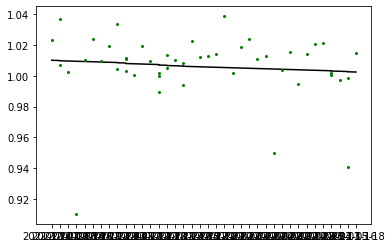

In [3]:
x = np.arange(target_customer.index.size)
fit = np.polyfit(x, target_customer["qoe"], 1)
fit_fn = np.poly1d(fit)

plt.plot(target_customer.index, fit_fn(x), 'k-')
plt.plot(target_customer.index, target_customer['qoe'], 'go', ms=2)
plt.show()

Split dataset

In [4]:
size = int(len(dataset) * 0.75)
train, test = dataset[0:size], dataset[size:len(dataset)]

train_dt = target_customer.index[0:size].to_numpy()
test_dt = target_customer.index[size:len(dataset)].to_numpy()

history = [h for h in train]

Scale dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(dataset)

scaled_train, scaled_test = scaled[0:size], scaled[size:len(dataset)]

Arima model

predicted=0.993319, expected=1.003899
predicted=0.996245, expected=1.015397
predicted=0.997820, expected=0.994584
predicted=0.979082, expected=1.014510
predicted=1.009336, expected=1.020702
predicted=1.011919, expected=1.021093
predicted=1.014975, expected=1.001919
predicted=1.006534, expected=1.000727
predicted=1.010249, expected=0.997284
predicted=1.008912, expected=0.998257
predicted=1.004754, expected=0.940635
predicted=0.978371, expected=1.015030
Test RMSE: 0.026


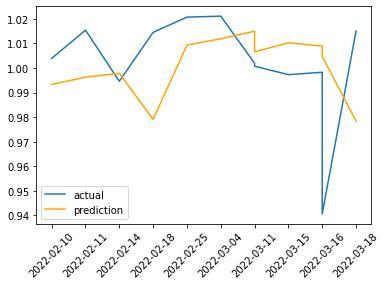

In [7]:
from statsmodels.tsa.arima.model import ARIMA

predictions = list()

for t in range(len(test)):

	model = ARIMA(history, order=(5, 1, 0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(test_dt, test, label='actual')
plt.plot(test_dt, predictions, color='orange', label='prediction')
plt.gca().xaxis.set_visible(True)
plt.gca().yaxis.set_visible(True)
for tick in plt.gca().get_xticklabels():

    tick.set_rotation(45)

plt.legend()
plt.show()

NARX model with Linear Regression

Test RMSE: 0.022


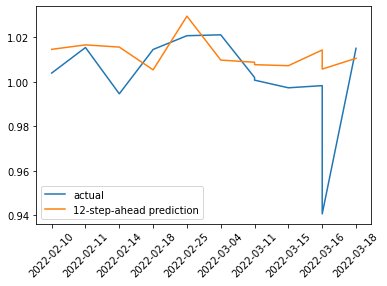

In [8]:
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX

x = np.arange(target_customer.index.size)
mdl = NARX(LinearRegression(), auto_order=6, exog_order=[3], exog_delay=[0])
mdl.fit(x[0:size].reshape(-1, 1), train.reshape(-1,))
y_forecast = mdl.forecast(x[size:len(x)].reshape(-1, 1), test.reshape(-1,), step=len(test))

rmse = sqrt(mean_squared_error(test, y_forecast))
print('Test RMSE: %.3f' % rmse)

plt.plot(test_dt, test, label='actual')
plt.plot(test_dt, y_forecast, label='{}-step-ahead prediction'.format(len(test)))
plt.gca().xaxis.set_visible(True)
plt.gca().yaxis.set_visible(True)
for tick in plt.gca().get_xticklabels():

    tick.set_rotation(45)
    
plt.legend()
plt.show()

MLPRegressor

/home/dimitris/Documents/University/Deep Learning/VENV/lib64/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test RMSE: 0.975


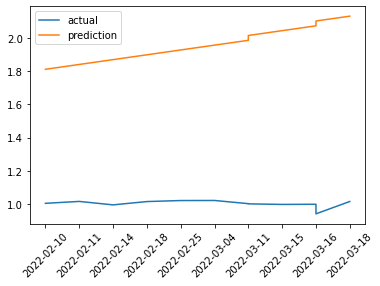

In [9]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(10,), activation="relu", solver="adam", learning_rate="adaptive")
model.fit(x[0:size].reshape(-1, 1), scaled_train.reshape(-1,))
y_forecast = model.predict(x[size:len(x)].reshape(-1, 1))

inverted_forecast = scaler.inverse_transform(y_forecast.reshape(-1, 1))

rmse = sqrt(mean_squared_error(test, inverted_forecast))
print('Test RMSE: %.3f' % rmse)

plt.plot(test_dt, test, label='actual')
plt.plot(test_dt, inverted_forecast, label='prediction')
plt.gca().xaxis.set_visible(True)
plt.gca().yaxis.set_visible(True)
for tick in plt.gca().get_xticklabels():

    tick.set_rotation(45)
    
plt.legend()
plt.show()

Recurrent NN

2022-06-17 19:31:29.364580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-17 19:31:29.364622: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-17 19:31:29.364653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (desktop-j4q4rob): /proc/driver/nvidia/version does not exist
2022-06-17 19:31:29.367559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2/2 - 3s - loss: 0.1850 - 3s/epoch - 2s/step
Epoch 2/10
2/2 - 0s - loss: 0.1850 - 11ms/epoch - 6ms/step
Epoch 3/10
2/2 - 0s - loss: 0.1849 - 14ms/epoch - 7ms/step
Epoch 4/10
2/2 - 0s - loss: 0.1849 - 47ms/epoch - 24ms/step
Epoch 5/10
2/2 - 0s - loss: 0.1848 - 16ms/epoch - 8ms/step
Epoch 6/10
2/2 - 0s - loss: 0.1847 - 20ms/epoch - 10ms/step
Epoch 7/10
2/2 - 0s - loss: 0.1847 - 13ms/epoch - 7ms/step
Epoch 8/10
2/2 - 0s - loss: 0.1846 - 27ms/epoch - 14ms/step
Epoch 9/10
2/2 - 0s - loss: 0.1846 - 14ms/epoch - 7ms/step
Epoch 10/10
2/2 - 0s - loss: 0.1845 - 11ms/epoch - 6ms/step
1/1 [==============================] - 1s 715ms/step
Test RMSE: 0.091


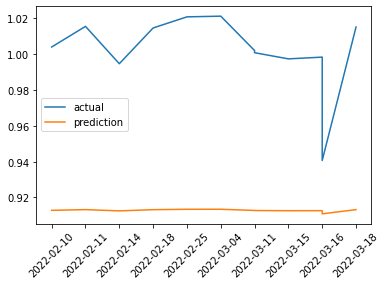

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam


rnn_model = Sequential()
rnn_model.add(LSTM(units=4, input_shape=(1, 1)))
rnn_model.add(Dense(units=1))
rnn_model.compile(
    loss='mean_squared_error',
    optimizer=Adam(0.00001)
)

rnn_model.fit(x[0:size].reshape(-1, 1), scaled_train.reshape(-1, 1), epochs=10, verbose=2)
y_forecast = rnn_model.predict(scaled_test.reshape(-1, 1))

inverted_forecast = scaler.inverse_transform(y_forecast.reshape(-1, 1))

rmse = sqrt(mean_squared_error(test, inverted_forecast))
print('Test RMSE: %.3f' % rmse)

plt.plot(test_dt, test, label='actual')
plt.plot(test_dt, inverted_forecast, label='prediction')
plt.gca().xaxis.set_visible(True)
plt.gca().yaxis.set_visible(True)
for tick in plt.gca().get_xticklabels():

    tick.set_rotation(45)
    
plt.legend()
plt.show()

Feed-forward NN

Epoch 1/10
2/2 - 1s - loss: 3.0167 - mse: 3.0167 - 1s/epoch - 508ms/step
Epoch 2/10
2/2 - 0s - loss: 2.4497 - mse: 2.4497 - 14ms/epoch - 7ms/step
Epoch 3/10
2/2 - 0s - loss: 1.9794 - mse: 1.9794 - 12ms/epoch - 6ms/step
Epoch 4/10
2/2 - 0s - loss: 1.5598 - mse: 1.5598 - 14ms/epoch - 7ms/step
Epoch 5/10
2/2 - 0s - loss: 1.1861 - mse: 1.1861 - 13ms/epoch - 7ms/step
Epoch 6/10
2/2 - 0s - loss: 0.8409 - mse: 0.8409 - 15ms/epoch - 8ms/step
Epoch 7/10
2/2 - 0s - loss: 0.5210 - mse: 0.5210 - 30ms/epoch - 15ms/step
Epoch 8/10
2/2 - 0s - loss: 0.2529 - mse: 0.2529 - 10ms/epoch - 5ms/step
Epoch 9/10
2/2 - 0s - loss: 0.0837 - mse: 0.0837 - 11ms/epoch - 6ms/step
Epoch 10/10
2/2 - 0s - loss: 0.0547 - mse: 0.0547 - 11ms/epoch - 6ms/step
1/1 [==============================] - 0s 185ms/step
Test RMSE: 0.061


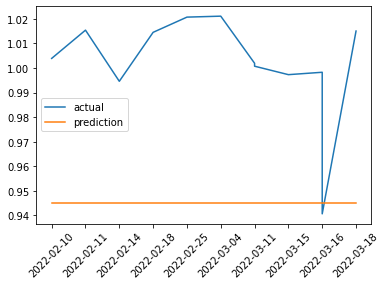

In [11]:
nn_model = Sequential()
nn_model.add(Dense(1))
nn_model.add(Dense(10, activation='sigmoid'))
nn_model.add(Dense(1, activation='linear'))
opt = Adam(learning_rate=0.01)
nn_model.compile(loss='mse', optimizer=opt, metrics=['mse'])

nn_model.fit(x[0:size].reshape(-1, 1),
              scaled_train.reshape(-1, 1), epochs=10, verbose=2)
y_forecast = nn_model.predict(scaled_test.reshape(-1, 1))

inverted_forecast = scaler.inverse_transform(y_forecast.reshape(-1, 1))

rmse = sqrt(mean_squared_error(test, inverted_forecast))
print('Test RMSE: %.3f' % rmse)

plt.plot(test_dt, test, label='actual')
plt.plot(test_dt, inverted_forecast, label='prediction')
plt.gca().xaxis.set_visible(True)
plt.gca().yaxis.set_visible(True)
for tick in plt.gca().get_xticklabels():

    tick.set_rotation(45)

plt.legend()
plt.show()

VAR model

Test RMSE: 159.231


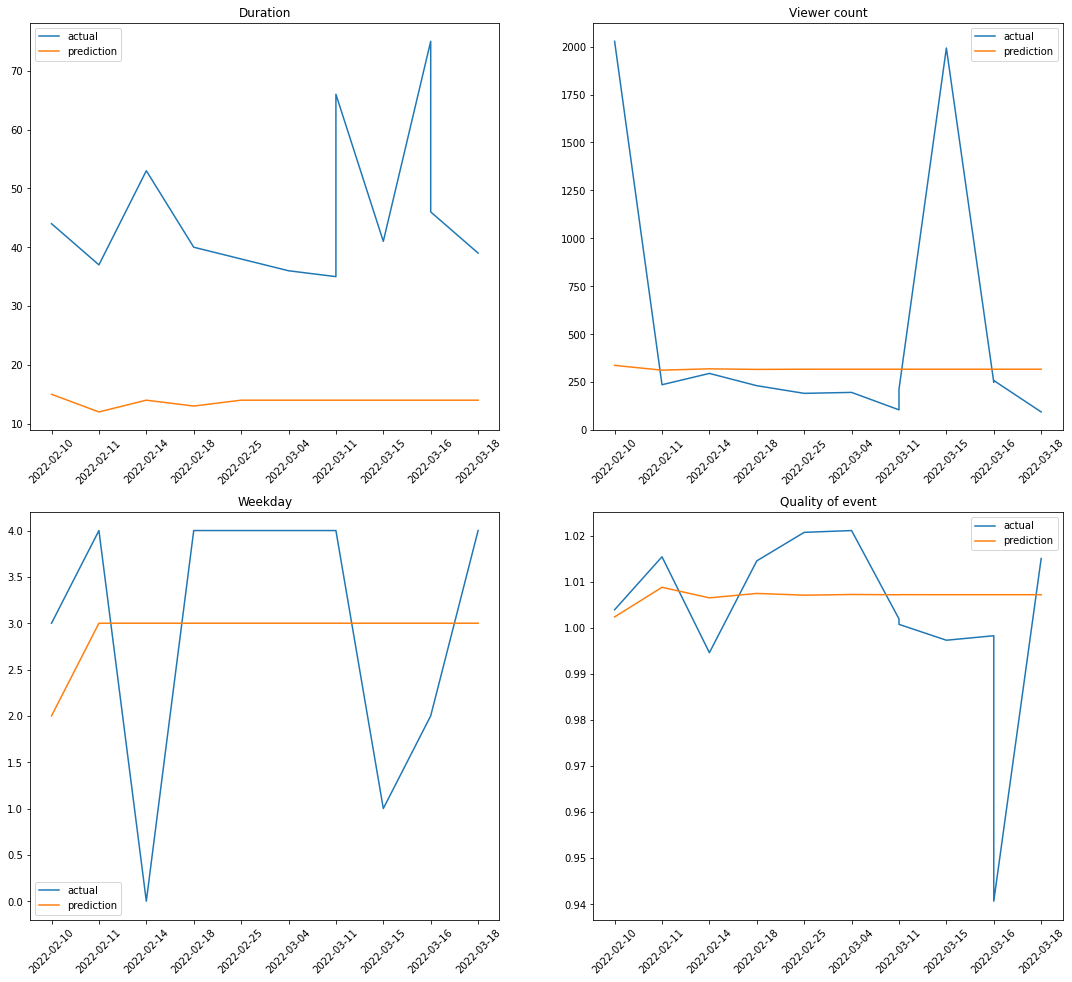

In [14]:
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.vector_ar.var_model import VAR

df = pd.read_csv("latest.csv")
target_customer = df.iloc[np.where(df["customer_id"] == 2.0)]
target_customer = target_customer[[
    "datetime", "qoe", "viewer_count", "weekday", "duration"]]
target_customer["duration"] = target_customer["duration"].astype("int")
target_customer = target_customer.sort_values(by="datetime")
target_customer = target_customer.set_index("datetime")

# set qoe as last column
cols = target_customer.columns.tolist()
cols[0], cols[-1] = cols[-1], cols[0]
target_customer = target_customer.reindex(columns=cols)

values = target_customer.values.astype('float32')

# integer encode direction
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:, 0])
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

train = scaled[:size]
test = scaled[size:]

model = VAR(endog=train)
model_fit = model.fit()
prediction = model_fit.forecast(test, steps=len(test))

inverted = scaler.inverse_transform(prediction.reshape(-1, 4))

inverted = pd.DataFrame(inverted, index=test_dt,
                        columns=target_customer.columns.tolist())

inverted = inverted.round({'duration': 0, 'viewer_count': 0, 'weekday': 0})

inverted[["duration", "viewer_count", "weekday"]
         ] = inverted[["duration", "viewer_count", "weekday"]].astype("int")


rmse = sqrt(mean_squared_error(test, inverted))
print('Test RMSE: %.3f' % rmse)

figure, axis = plt.subplots(2, 2)

figure.set_size_inches(18.5, 16.5)

axis[0, 0].plot(test_dt, target_customer[size:]
                ["duration"].to_numpy(), label='actual')
axis[0, 0].plot(test_dt, inverted["duration"].to_numpy(), label='prediction')
axis[0, 0].set_title("Duration")
axis[0, 0].xaxis.set_visible(True)
axis[0, 0].yaxis.set_visible(True)
for tick in axis[0, 0].get_xticklabels():

    tick.set_rotation(45)

axis[0, 0].legend()

axis[0, 1].plot(test_dt, target_customer[size:]
                ["viewer_count"].to_numpy(), label='actual')
axis[0, 1].plot(test_dt, inverted["viewer_count"].to_numpy(),
                label='prediction')
axis[0, 1].set_title("Viewer count")
axis[0, 1].xaxis.set_visible(True)
axis[0, 1].yaxis.set_visible(True)
for tick in axis[0, 1].get_xticklabels():

    tick.set_rotation(45)

axis[0, 1].legend()

axis[1, 0].plot(test_dt, target_customer[size:]
                ["weekday"].to_numpy(), label='actual')
axis[1, 0].plot(test_dt, inverted["weekday"].to_numpy(), label='prediction')
axis[1, 0].set_title("Weekday")
axis[1, 0].xaxis.set_visible(True)
axis[1, 0].yaxis.set_visible(True)
for tick in axis[1, 0].get_xticklabels():

    tick.set_rotation(45)

axis[1, 0].legend()

axis[1, 1].plot(test_dt, target_customer[size:]
                ["qoe"].to_numpy(), label='actual')
axis[1, 1].plot(test_dt, inverted["qoe"].to_numpy(), label='prediction')
axis[1, 1].set_title("Quality of event")
axis[1, 1].xaxis.set_visible(True)
axis[1, 1].yaxis.set_visible(True)
for tick in axis[1, 1].get_xticklabels():

    tick.set_rotation(45)


axis[1, 1].legend()

plt.show()
